In [1]:
import copy
import warnings

import numpy as np
import xarray as xr

import sys, pdb, traceback

import matplotlib.pyplot as plt

import rotunno as rt
import qian_helpers
import rotunno_helpers

In [626]:
from sympy import *

In [627]:
kappa, U, x, tau, L =symbols('kappa U x tau L')
kappaU = 1/U

In [628]:
expression = (kappa/(kappa*U-1))/(kappa**2+(U*kappa-1)**2)*exp(-kappa*L)*exp(I*(kappa*x-tau))-(2*kappaU-kappa)/(kappa*U-1)/((2*kappaU-kappa)**2+(kappa*U-1)**2)*exp(-1*(2*kappaU-kappa)*L)*exp(I*((2*kappaU-kappa)*x-tau))

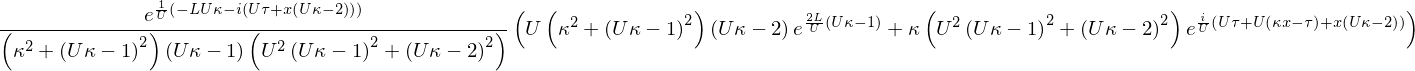

In [639]:
simplify(expression)

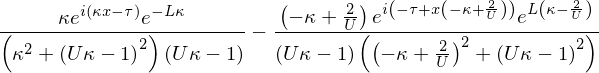

In [629]:
init_printing()
expression

In [630]:
limit(expression,kappa,kappaU)

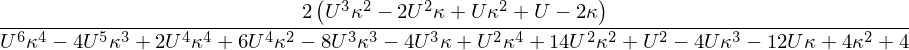

In [615]:
simplify(cancel(factor(cancel(expand(exp)))))

In [271]:
theta_alt = ((1-cos(s*pi))/(2))**(alpha)*pi/2

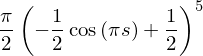

In [272]:
theta_alt.subs(alpha,5)

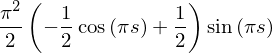

In [275]:
diff(theta_alt.subs(alpha,2),s)

In [255]:
init_printing()

In [571]:
# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport rotunno 

In [2]:
ds = xr.open_dataset('/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/datasets/qian_20191121_081203.nc')

In [646]:
ds_qian = rt.solve_qian(xiN=81, zetaN=41, tauN=16, sN=2000, U=0.25, L=0.1, alpha=3, save=False)
# ds_rotunno = rt.solve_rotunno_case_two(xiN=81, zetaN=41, tauN=16, kN=1000,
#                                        xi0=0.2, beta=0.007195175718401071)

Initialising
Integrating
100%|██████████| 40/40 [04:59<00:00,  7.49s/it]
Saving


/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: ComplexWarning: Cas

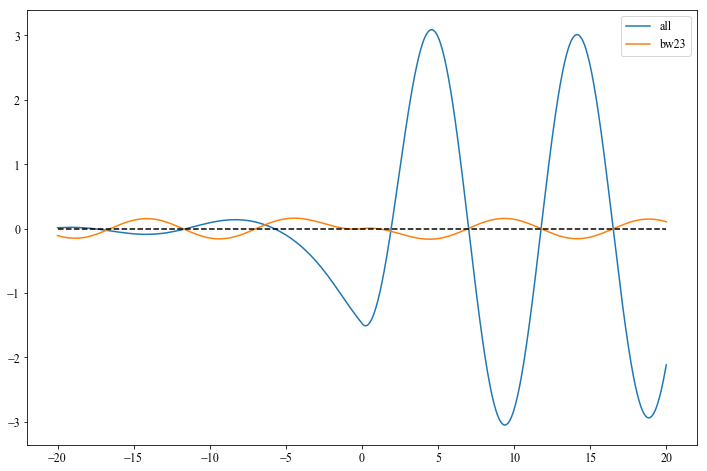

In [774]:
plt.close('all')
power=6
tau=np.pi/2
zeta=0.001
alpha=3
U=1.5
L=0.1
sN=1000
dS=1/sN

s=np.arange(dS,1,dS, dtype=np.float32)
xi=np.linspace(-20,20,1000, dtype=np.float32)
theta=qian_helpers.calc_theta(s,alpha)

k2 = qian_helpers.calc_k_2(theta,U)
k3 = qian_helpers.calc_k_3(theta,U)
k0_2 = qian_helpers.calc_k_2(0,U)
k0_3 = qian_helpers.calc_k_3(0,U)
bw23=np.zeros(xi.size)
bw23_alt=np.zeros(xi.size)
bw23a=np.zeros(xi.size)
bw23b=np.zeros(xi.size)
bw2b=np.zeros(xi.size)
bw2ba=np.zeros(xi.size)
bw2c=np.zeros(xi.size)
bw3b=np.zeros(xi.size)
bw3c=np.zeros(xi.size)

# def calc_k_2()

def calc_test(xi,zeta,tau,theta,U,L):
    test_exp = (
        U**2*(-(U**2 + (U**2*(-np.sin(theta) + 1) - 1)**2)
              *np.exp((-L*(np.sin(theta) - 1)**2 + 1j*(U*tau*(-np.sin(theta) + 1) - xi))/(U*(-np.sin(theta) + 1)))
              +(U**2*(np.sin(theta) - 1)**2 + (U**2 + np.sin(theta) - 1)**2)
              *np.exp((L + 1j*(np.sin(theta) - 1)*(U*tau + xi*np.sin(theta) - xi))/(U*(np.sin(theta) - 1))))
        *np.exp(1j*(-U*tau*(-np.sin(theta) + 1) + xi - (-np.sin(theta) + 1)*(U*tau + xi*np.sin(theta) - xi))/(U*(-np.sin(theta) + 1)))
        /((U**2 + (U**2*(-np.sin(theta) + 1) - 1)**2)
          *(U**2*(np.sin(theta) - 1)**2 + (U**2 + np.sin(theta) - 1)**2)
          *np.tan(theta))
    )
    return test_exp

for i in range(xi.size):
    bw23a_ig = (1/np.tan(theta)
               *(
                 -qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2
#                  +qian_helpers.calc_C3(xi[i],tau,k3,U,L)
                )
               *alpha*s**(alpha-1)*np.pi/2)
    bw23b_ig = (1/np.tan(theta)
               *(
#                  -qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2
                 +qian_helpers.calc_C3(xi[i],tau,k3,U,L)
                )
               *alpha*s**(alpha-1)*np.pi/2)
    bw23_ig = ((-qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2/np.tan(theta)
                +qian_helpers.calc_C3(xi[i],tau,k3,U,L)/np.tan(theta))
               *alpha*s**(alpha-1)*np.pi/2)
    
    s_app=np.concatenate(([0],s,[1]))
    bw23_ig_app=np.concatenate(([0],bw23_ig,[0]))
    
#     bw23_ig_alt = calc_test(xi[i],zeta,tau,theta,U,L)*alpha*s**(alpha-1)*np.pi/2
    
    bw23a[i] = np.trapz(bw23a_ig,s)*1/2*np.exp(-zeta)
    bw23b[i] = np.trapz(bw23b_ig,s)*1/2*np.exp(-zeta)
    bw23[i] = np.trapz(bw23_ig_app,s_app)*1/2*np.exp(-zeta)
#     bw23_alt[i] = np.trapz(bw23_ig_alt,s)*1/2*np.exp(-zeta)
    bw2c[i] = (1/(2*U**2)*np.exp(1j*zeta/U)
               *qian_helpers.calc_C2(xi[i],tau,k0_2,U,L)
               *qian_helpers.calc_exp1(1j*zeta/U))
    bw2b[i] = np.trapz(qian_helpers.calc_bw2b(xi[i],zeta,tau,s,alpha,U,L),s)
    bw3b[i] = np.trapz(qian_helpers.calc_bw3b(xi[i],zeta,tau,s,alpha,U,L),s)
    bw3c[i] = (-1/2*qian_helpers.calc_C3(xi[i],tau,k0_3,U,L)
                        *qian_helpers.calc_exp1(-1j*zeta/U))
    
    # Calc psi2
    psi2a_ig = qian_helpers.calc_psi2a(xi[i],zeta,tau,s,alpha,U,L)
    psi2b_ig = qian_helpers.calc_psi2b(xi[i],zeta,tau,s,alpha,U,L)
    
    psi2c = (-1/(2*U)*np.exp(1j*zeta/U)
             *qian_helpers.calc_C2(xi[i],tau,k0_2,U,L)
             *qian_helpers.calc_ep0(-1j*zeta/U))

    psi2ab = np.trapz(psi2a_ig+psi2b_ig, s)
    bw2ba[i] = (psi2ab+psi2c)/U
        
# plt.figure(figsize=(12,8))
# plt.plot(xi,bw23a,label='bw23a')
# plt.plot(xi,bw23b,label='bw23b')
# plt.plot(xi,bw23_alt,label='bw23')
# plt.plot(xi,np.zeros(xi.size),'--k')
# plt.plot(xi,bw2b,label='bw2b')
# plt.plot(xi,bw2c,label='bw2c')
# plt.plot(xi,bw3b,label='bw3b')
# plt.plot(xi,bw3c,label='bw3c')
# plt.plot(s,k2,'.')
# plt.plot(s[0:4000],k3[0:4000]-1.25,'.')

# plt.figure(figsize=(12,8))
# plt.plot(s[0:800],k3[0:800],'.')

# plt.legend()
# plt.show()
plt.figure(figsize=(12,8))

# plt.plot(xi,bw2ba,label='bw2ba')
# plt.plot(xi,bw3b+bw3c+bw2b,label='bw3b+bw3c')
plt.plot(xi,bw2b+bw2c+bw3b+bw3c,label='all')
# plt.plot(xi,bw2c,label='bw2b+bw2c')
# plt.plot(xi,bw23_alt,label='bw23_alt')
# plt.plot(xi,bw23a,label='bw23a')
# plt.plot(xi,bw23b,label='bw23b')
# plt.plot(xi,bw23,label='bw23')
# plt.plot(xi,bw23+bw2ba,label='bw23')
# plt.plot(xi,bw3b+bw3c+bw23+bw23+bw2c,label='all')
# plt.plot(xi,bw23a+bw23b,label='bw23a+bw23b')
# plt.plot(xi,bw23,label='bw23')
plt.plot(xi,np.zeros(xi.size),'--k')
plt.legend()
plt.show()

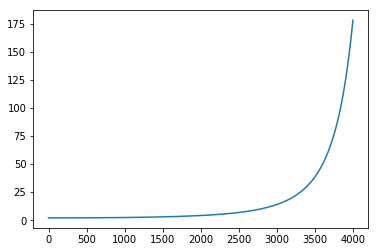

In [49]:
plt.plot(k3_alt[0:4000])

In [40]:
bw23_ig_app[np.isnan(bw23_ig_app)]=0

In [41]:
bw23_ig_app

array([ 0.        +0.j        , -0.00338089+0.01583322j,
       -0.00676179+0.03166646j, ...,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])

In [46]:
print(bw23b_ig[-1])
print(bw23a_ig[-1])
print(bw23_ig[-1])

print(bw23b_ig[0])
print(bw23a_ig[0])
print(bw23_ig[0])

0j
(-0.04786586508048484+0.07451034415384471j)
(-0.04786586508048484+0.07451034415384471j)
(2428.4484169397124+368.1272879785263j)
(-2428.4484492248675-368.12713678238697j)
(-3.228515554674593e-05+0.00015119613923476432j)


/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


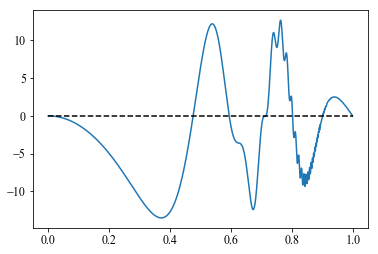

In [120]:
s_app=np.concatenate(([0],s,[1]))
bw23_ig_app=np.concatenate(([0],bw23_ig,[0]))

plt.plot(s_app,bw23_ig_app)
plt.plot(s_app,np.zeros(s_app.size),'--k');
plt.show()

# plt.plot(s[200:],bw23a_ig[200:])
# plt.plot(s[200:],bw23b_ig[200:])

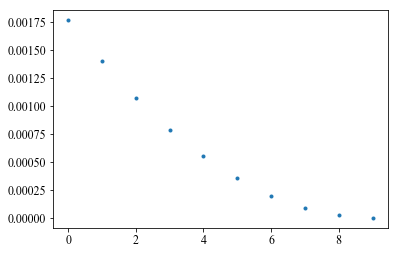

In [57]:

k2_app = np.concatenate((k2,[0]))
plt.plot(k2_app[-10:],'.'); plt.show()

/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


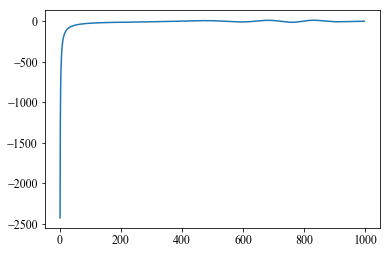

In [14]:
plt.plot(bw23a_ig); plt.show()

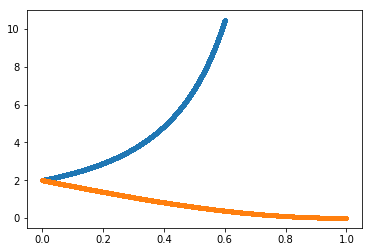

In [162]:
plt.plot(s[0:30000],k3[0:30000],'.')
plt.plot(s,k2,'.')

In [3]:
def calc_theta_alt(s,alpha=1):
    theta_alt = ((1-np.cos(s*np.pi))/(2))**(alpha)*np.pi/2
    return theta_alt

def calc_dtheta_alt(s,alpha=1):
    dtheta_alt = (np.pi/2*alpha*((1-np.cos(s*np.pi))/2)**(alpha-1)
                  *np.sin(s*np.pi)*np.pi/2)
    return dtheta_alt

AttributeError: Unknown property size

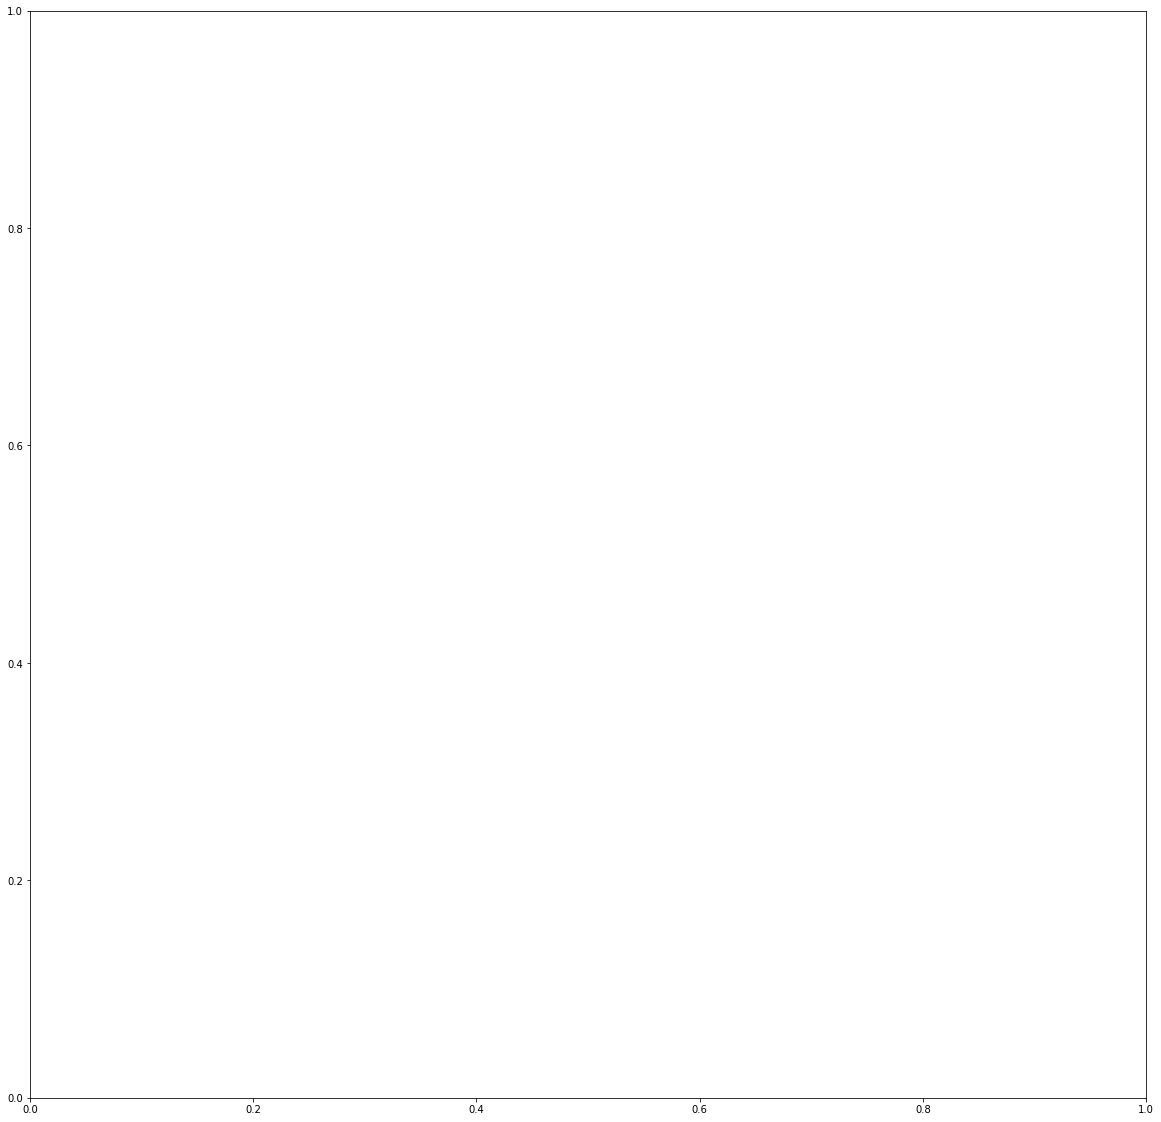

In [100]:
plt.figure(figsize=(20,20))
plt.plot(s[200:2500],k3[200:2500],'.',size=0.1)

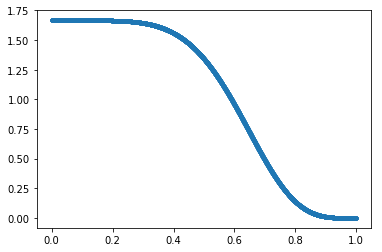

In [95]:
plt.plot(s,k2,'.')

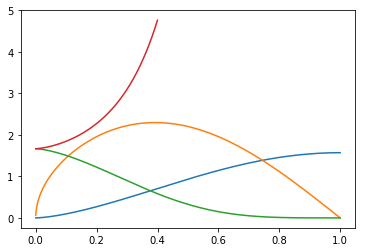

In [110]:
# plt.plot(s,theta_alt)
alpha=0.75
theta_alt=calc_theta_alt(s,alpha)
k2 = qian_helpers.calc_k_2(theta_alt,U)
k3 = qian_helpers.calc_k_3(theta_alt,U)

plt.plot(s,calc_theta_alt(s, alpha))
# plt.plot(s,calc_theta_alt(s))
# k2_alt = qian_helpers.calc_k_2(calc_theta_alt(s),U)
# k3_alt = qian_helpers.calc_k_3(calc_theta_alt(s),U)
# plt.plot(s[0:100],k3_alt[0:100],'.')
plt.plot(s,calc_dtheta_alt(s,alpha=alpha))
plt.plot(s,k2)
plt.plot(s[:-3000],k3[:-3000])

(-12.329049350899066373-35.53499370414042801j)
(14.835418260372640877+34.478900057283078752j)
(2.5063689094735745033-1.056093646857349258j)
(2.5063689094735745028-1.0560936468573492554j)
(2.5063689094735745024-1.056093646857349256j)


/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


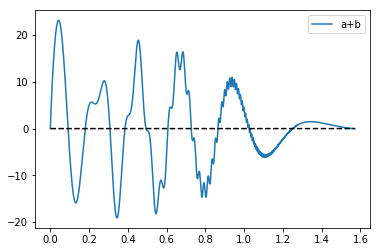

In [83]:
x=-20.10
alpha=3
U=0.6
tau=3
L=0.1
sN=5000
dS=1/sN

s=np.arange(dS,1,dS,dtype=np.float128)
theta=calc_theta_alt(s,alpha)

k2 = qian_helpers.calc_k_2(theta,U)
k3 = qian_helpers.calc_k_3(theta,U)
k0_2 = qian_helpers.calc_k_2(0,U)
k0_3 = qian_helpers.calc_k_3(0,U)

# bw23a_ig = (1/np.tan(theta)
#                *(
#                  -qian_helpers.calc_C2(x,tau,k2,U,L)/U**2
# #                  +qian_helpers.calc_C3(xi[i],tau,k3,U,L)
#                 )
#                *alpha*s**(alpha-1)*np.pi/2)
# bw23b_ig = (1/np.tan(theta)
#            *(
# #                  -qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2
#              +qian_helpers.calc_C3(x,tau,k3,U,L)
#             )
#            *alpha*s**(alpha-1)*np.pi/2)

bw23a_ig = (1/np.tan(theta)
               *(
                 -qian_helpers.calc_C2(x,tau,k2,U,L)/U**2
#                  +qian_helpers.calc_C3(xi[i],tau,k3,U,L)
                )
#                *alpha*s**(alpha-1)*np.pi/2)*1/2*np.exp(-zeta)
                *calc_dtheta_alt(s,alpha))
bw23b_ig = (1/np.tan(theta)
           *(
#                  -qian_helpers.calc_C2(xi[i],tau,k2,U,L)/U**2
             +qian_helpers.calc_C3(x,tau,k3,U,L)
            )
#            *alpha*s**(alpha-1)*np.pi/2)*1/2*np.exp(-zeta)
            *calc_dtheta_alt(s,alpha))
bw23_ig = (1/np.tan(theta)
           *(
             -qian_helpers.calc_C2(x,tau,k2,U,L)
             +qian_helpers.calc_C3(x,tau,k3,U,L)*U**2
            )
#            *alpha*s**(alpha-1)*np.pi/2)*1/2*np.exp(-zeta)
            *calc_dtheta_alt(s,alpha))

where_nan = np.logical_or(np.isnan(bw23a_ig),np.isnan(bw23b_ig))
bw23a_ig[where_nan]=0
bw23b_ig[where_nan]=0
bw23_ig[np.isnan(bw23_ig)]=0

# plt.plot(theta[3:10],bw23a_ig[3:10],label='a')
# plt.plot(theta[3:10],bw23b_ig[3:10],label='b')
# plt.plot(theta,(bw23b_ig+bw23a_ig),label='a+b')
plt.plot(theta,bw23_ig/U**2, label='a+b')
plt.plot(theta, np.zeros(theta.size),'--k')
plt.legend()

# s_app = np.concatenate(([0],s,[1]))
# bw

print(np.trapz(bw23a_ig,s))
print(np.trapz(bw23b_ig,s))
print(np.trapz(bw23a_ig,s)+np.trapz(bw23b_ig,s))
print(np.trapz(bw23a_ig+bw23b_ig,s))
print(np.trapz(bw23_ig/U**2,s))


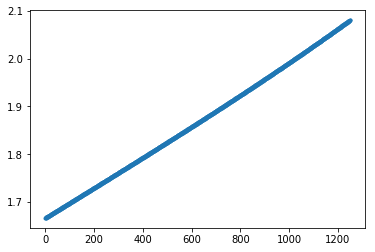

In [128]:
plt.plot(np.tan(np.arange(0,np.pi/8,np.pi/(2*5000)))+1/U,'.')

(-0.5179932269297006+0.23705734171486845j)
(-0.0025924674580250088-0.001788298253617036j)


/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


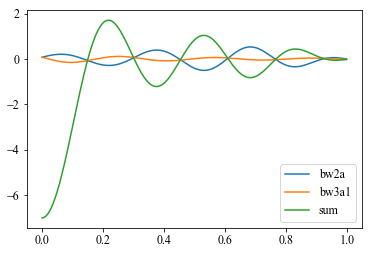

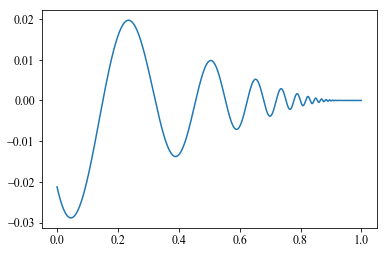

In [660]:
# Alternative approach
sN=2000
dk = (1/U)/sN
s=np.arange(1/sN,1,1/sN)
U=0.5
L=0.5
alpha=1

k2 = (1-s**alpha)/U

k3 = np.tan((np.arange(0,1+1/sN,1/sN))*np.pi/2)+2/U
x=10
tau=0
zeta=0.00001

def calc_exp_terms(xi,tau,k,L):
    return np.exp(-k*L)*np.exp(1j*(k*xi-tau)) 

# bw2a_ig = qian_helpers.calc_C2(x,tau,k2,U,L)*k2/(U*k2-1)*alpha*s**(alpha-1)
bw2a_ig = qian_helpers.calc_C2(x,tau,k2,U,L)*k2*alpha*s**(alpha-1)
# bw2a_ig_alt = qian_helpers.calc_C2(x,tau,k2,U,L)*alpha*s**(alpha-1)
bw2a_ig[np.isinf(bw2a_ig)]=0

k2P = -k2+2/U

# bw3a1_ig = qian_helpers.calc_C2(x,tau,k2P,U,L)*k2P/(1-U*k2)*alpha*s**(alpha-1)
bw3a1_ig = qian_helpers.calc_C2(x,tau,k2P,U,L)*k2P*alpha*s**(alpha-1)
# bw3a1_ig_alt = qian_helpers.calc_C2(x,tau,k2P,U,L)*alpha*s**(alpha-1)
bw3a1_ig[np.isinf(bw3a1_ig)]=0

bw3a2_ig = qian_helpers.calc_C2(x,tau,k3,U,L)*k3/(U*k3-1)

# plt.plot(k2[-10:],'o')
# plt.plot(k3[:10],'o')
# plt.plot(k3[:10]*0+2,'--')

# *np.exp(-zeta)

lb=0
ub=100

# plt.plot(s,bw2a_ig+bw3a1_ig)
plt.plot(s,bw2a_ig,label='bw2a')
plt.plot(s,bw3a1_ig, label='bw3a1')
plt.plot(s,(-bw3a1_ig+bw2a_ig)/(k2*U-1), label='sum')
plt.legend()
print(np.trapz((-bw3a1_ig+bw2a_ig)/(k2*U-1),s))
plt.plot()
# plt.plot(k2,bw2a_ig)
plt.figure()
plt.plot(np.arange(0,1+1/sN,1/sN),bw3a2_ig)
print(np.trapz(bw3a2_ig,k3))

# plt.plot(np.concatenate((bw2a_ig,bw3a_ig)))
# print(np.trapz(bw2a_ig[:100],k2[:100]))
# print(np.trapz(bw3a_ig[100:],k3[100:]))
# print(np.trapz(bw2a_ig[-100:],k2[-100:]))
# print(np.trapz(bw3a_ig[0:100],k3[0:100]))

In [637]:
-2*0.5*np.exp(-1)-2*0.5*np.exp(-1)

In [638]:
((-bw3a1_ig+bw2a_ig)/(k2*U-1))[0]

(-0.7357590356260302-0j)

In [533]:
(-bw3a1_ig+bw2a_ig)

array([ 0.        +0.j        , -0.03080834-0.02439352j,
       -0.06154299-0.04873447j, ...,  0.01747324+0.15700122j,
        0.0229988 +0.15634311j,  0.02845792+0.15513378j])

In [472]:
print(bw2a_ig[0:5])
print(bw3a1_ig[0:5])

[370.75729701+174.70488603j 183.81522508 +91.1516835j
 121.44950398 +63.28231417j  90.22810567 +49.33311486j
  71.4646373  +40.95135606j]
[-376.54227614-159.3558899j  -189.59942448 -75.80587352j
 -127.23240394 -47.94181354j  -96.00918662 -34.00004553j
  -77.24337988 -25.62783814j]


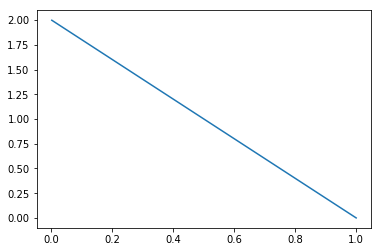

In [479]:
plt.plot(s,k2)

In [ ]:
(bw2a_ig)[:10]
(bw3a1_ig)[:10]

In [302]:
print(bw3a1_ig[[0,-1]])
print(bw2a_ig[[0,-1]])

[-1.23348671e+02-1.37806966e+02j -6.73731274e-03+6.06604392e-02j]
[123.348674+137.8069914j   0.        +0.j       ]


In [304]:
(bw2a_ig+bw3a1_ig)[-1]

(-0.00673731274354698+0.06066043920353838j)

In [253]:
(bw2a_ig+bw3a1_ig)[-10:]

array([9.82265093+0.91728345j, 9.82265112+0.91728338j,
       9.82265128+0.91728339j, 9.82265139+0.91728359j,
       9.82265153+0.91728341j, 9.82265167+0.91728299j,
       9.82265161+0.91728417j, 9.82265175+0.91728342j,
       9.82265254+0.91727662j,       -inf       +infj])

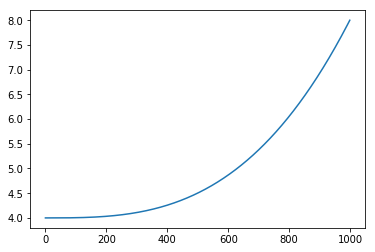

In [309]:
plt.plot(k2P)

In [310]:
np.trapz(bw3a2_ig,s)

ValueError: operands could not be broadcast together with shapes (999,) (999998,) 

In [78]:
lb=0
ub=None
print(np.trapz(bw23_ig[lb:ub],s[lb:ub]))
print(theta[lb])
print(theta[ub])
print('k2 bounds')
print(k2[lb])
print(k2[ub])
print('k3 bounds')
print(k3[lb])
print(k3[ub])

(2.657889604570175655-0.31576156285796772773j)
1.5101464648428811832e-21
[[1.51014646e-21 9.66493451e-20 1.10089590e-18 ... 1.57079214e+00
  1.57079447e+00 1.57079586e+00]]
k2 bounds
1.6666666666666667283
[[1.66666667e+00 1.66666667e+00 1.66666667e+00 ... 1.46010638e-11
  2.88416453e-12 1.80260447e-13]]
k3 bounds
1.6666666666666667283
[[1.66666667e+00 1.66666667e+00 1.66666667e+00 ... 1.90244890e+11
  9.63113493e+11 1.54098019e+13]]


In [342]:
bw23_ig.max()

(17.261335848411099348-1.0528039516075506007j)

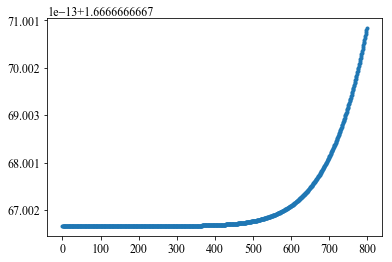

In [321]:
plt.plot(k3[0:800],'.')

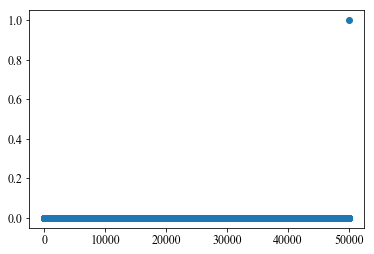

In [292]:
np.logical_or(np.isnan(bw23a_ig),np.isnan(bw23b_ig))

# bw23b_ig[-10:]

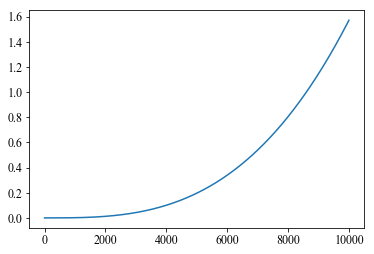

In [169]:
plt.plot(theta)

In [106]:
ig=(bw23b_ig+bw23a_ig)
ig[np.isnan(bw23b_ig+bw23a_ig)]=0
np.trapz(ig,s)

(-0.8360863131183129-0.360964628529348j)

(0.35736927156052356+0.639392571768856j)
(0.5022095881000948+0.521705376655576j)
(0.613298983485386+0.3733400858443321j)
(0.6843824628974678+0.20371579543362425j)


/home/student.unimelb.edu.au/shorte1/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


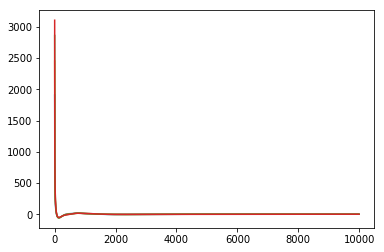

In [179]:
bw23_ig_alt_1 = calc_test(-10.00,zeta,6*2*np.pi/10,theta,U,L)*alpha*s**(alpha-1)*np.pi/2
bw23_ig_alt_2 = calc_test(-10.20,zeta,6*2*np.pi/10,theta,U,L)*alpha*s**(alpha-1)*np.pi/2
bw23_ig_alt_3 = calc_test(-10.40,zeta,6*2*np.pi/10,theta,U,L)*alpha*s**(alpha-1)*np.pi/2
bw23_ig_alt_4 = calc_test(-10.60,zeta,6*2*np.pi/10,theta,U,L)*alpha*s**(alpha-1)*np.pi/2

plt.plot(bw23_ig_alt_1)
print(np.trapz(bw23_ig_alt_1,s)*1/2*np.exp(-zeta))
plt.plot(bw23_ig_alt_2)
print(np.trapz(bw23_ig_alt_2,s)*1/2*np.exp(-zeta))
plt.plot(bw23_ig_alt_3)
print(np.trapz(bw23_ig_alt_3,s)*1/2*np.exp(-zeta))
plt.plot(bw23_ig_alt_4)
print(np.trapz(bw23_ig_alt_4,s)*1/2*np.exp(-zeta))

In [157]:
k3[8000]

8.036649021604719

In [149]:
len(k2)

9999

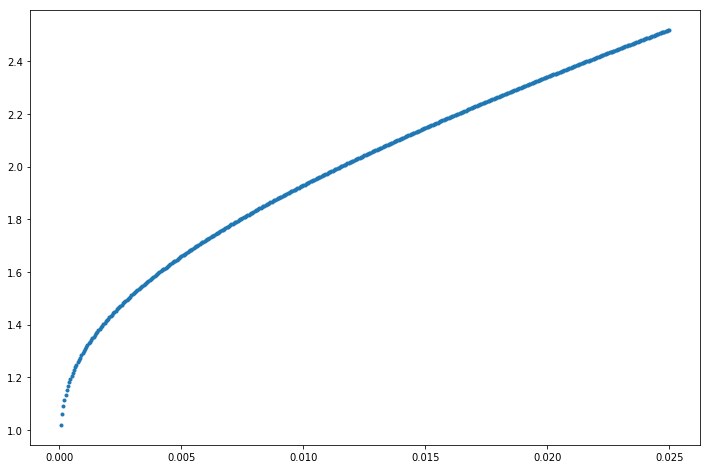

In [61]:
plt.figure(figsize=(12,8))
plt.plot(s[0:500],k3[0:500],'.')

In [647]:
omega = 2*np.pi/(24*3600)
# ds_rotunno_dim = rt.redimensionalise_rotunno(copy.deepcopy(ds_rotunno), h=5000, f=0, N=0.035)
ds_qian_dim = rt.redimensionalise_qian(copy.deepcopy(ds_qian), h=1500, N=0.01, Q0=10**3*omega**3*1500*np.pi)

In [653]:
ds_qian_dim

<xarray.Dataset>
Dimensions:  (mode: 3, submode: 6, tau: 16, xi: 81, zeta: 41)
Coordinates:
  * mode     (mode) int64 1 2 3
  * tau      (tau) float64 0.0 5.4e+03 1.08e+04 ... 7.02e+04 7.56e+04 8.1e+04
  * zeta     (zeta) float64 0.0 375.0 750.0 ... 1.425e+04 1.462e+04 1.5e+04
  * xi       (xi) float64 -1.238e+06 -1.207e+06 ... 1.207e+06 1.238e+06
  * submode  (submode) int64 1 2 3 4 5 6
Data variables:
    psi      (mode, tau, zeta, xi) float32 0.0 0.0 0.0 ... -4.59991 -0.558269
    u        (mode, tau, zeta, xi) float32 -0.013009815 ... 0.013868671
    w        (mode, tau, zeta, xi) float32 0.0 0.0 ... -0.00020070057
    bq       (tau, zeta, xi) float32 1.6827054e-05 ... -2.9588705e-06
    bw       (submode, tau, zeta, xi) float32 0.0 0.0 ... 6.636624e-05
Attributes:
    U:        3.75
    L:        20626.480624709635
    Q0:       1.8123393054201529e-06
    h:        1500
    N:        0.01
    omega:    7.27220521664304e-05

Plotting bw.
Timestep 0
Timestep 0
Timestep 1
Timestep 2
Timestep 3
Timestep 4
Timestep 5
Timestep 6
Timestep 7
Timestep 8
Timestep 9
Timestep 10
Timestep 11
Timestep 12
Timestep 13
Timestep 14
Timestep 15


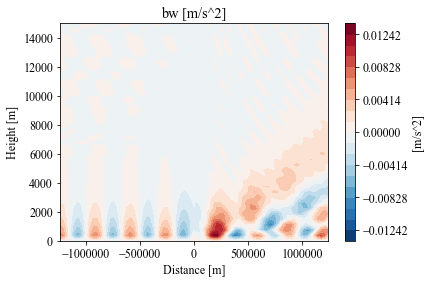

In [776]:
# rt.animateCont(ds_qian_dim.sum(dim='mode', keep_attrs=True).squeeze(),var='psi')
# rt.animatePsi(ds_dim.sel(mode=2).squeeze())
# rt.animateCont(ds_qian_dim.sel(mode=[2,3]).sum(dim='mode', keep_attrs=True).squeeze(),  var='bw')
# rt.animateCont(ds_qian_dim.sel(mode=[2]).sum(dim='mode', keep_attrs=True).squeeze(),  var='psi')
# for i in np.arange(1,7):
#     rt.animateCont(ds_qian_dim.sel(submode=i),  var='bw')
rt.animateCont(ds_qian_dim.sel(submode=[2,3,4,5,6]).sum(dim='submode', keep_attrs=True).squeeze(),'bw')
# rt.animateCont(ds_qian_dim.sel(mode=2).squeeze(),  var='psi')

Plotting w.


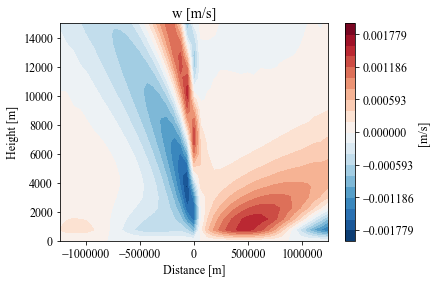

In [22]:
rt.plotCont(ds_qian_dim.sel(mode=[1,2]).sum(dim='mode', keep_attrs=True).squeeze(), t=5, var='w'); plt.show()

In [51]:
ds_qian_dim['theta_pert'] = ds_qian_dim.bw*300/9.807
ds_qian_dim.theta_pert.attrs['units'] = 'K'

Plotting bw.


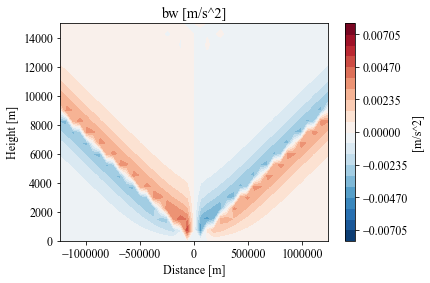

In [12]:
rt.plotCont(ds_qian_dim.sel(mode=[1,2]).sum(dim='mode', keep_attrs=True).squeeze(), t=8, var='bw'); plt.show()

Plotting w.


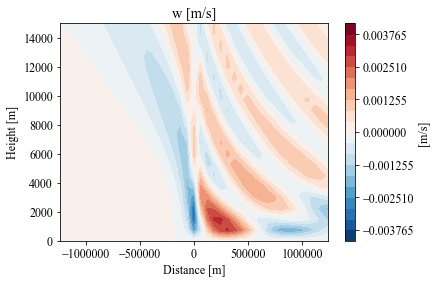

In [23]:
# plt.close('all'); rt.plotCont(ds_qian_dim.sel(mode=2).squeeze(), t=7, var='bw'); plt.show()
rt.plotCont(ds_qian_dim.sel(mode=[1,2,3]).sum(dim='mode', keep_attrs=True).squeeze(), t=1, var='w'); plt.show()

In [14]:
ds_qian_dim['bw'].sel(submode=1)


<xarray.DataArray 'bw' (tau: 32, zeta: 21, xi: 41)>
array([[[ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        [ 1.958886e-05,  1.978248e-05, ...,  2.110002e-05,  1.966475e-05],
        ...,
        [-3.019598e-04, -3.295311e-04, ...,  1.731370e-05,  1.723720e-05],
        [-3.230871e-04, -3.459937e-04, ...,  1.616347e-05,  1.623230e-05]],

       [[ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        [ 1.253797e-05,  1.192640e-05, ...,  2.412829e-05,  2.243550e-05],
        ...,
        [-3.095749e-04, -3.302517e-04, ...,  1.755676e-05,  1.752399e-05],
        [-3.222571e-04, -3.369935e-04, ...,  1.638255e-05,  1.643084e-05]],

       ...,

       [[ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        [ 3.119024e-05,  3.294125e-05, ...,  1.275841e-05,  1.199163e-05],
        ...,
        [-2.526559e-04, -2.906132e-04, ...,  1.486644e-05,  1.471285e-05],
        [-2.879442e-04, -3.242702e-04, ...,  1.389414e-05,  1.39954

In [3]:
rt.animateCont(ds_qian_dim.sel(mode=3).squeeze(),  var='bw')

NameError: name 'ds_qian_dim' is not defined

In [19]:
# rt.animateVelocity(ds.sum(dim='mode', keep_attrs=True).squeeze())
# rt.animateVelocity(ds_rotunno_dim)
# rt.animateVelocity(ds_qian_dim.sum(dim='mode', keep_attrs=True).squeeze())
rt.animateVelocity(ds_qian_dim.sel(mode=2).squeeze())

Plotting velocity.
Timestep 0
Timestep 0
Timestep 1
Timestep 2
Timestep 3
Timestep 4
Timestep 5
Timestep 6
Timestep 7


In [ ]:
rt.plotVelocity(ds_qian_dim.sum(dim='mode', keep_attrs=True).squeeze(), t=3); plt.show()